In [1]:
import gym
import gym_example
from utils import *

# Training protagonist and adversary

To train adversarial v-3, which includes training of the protagonist to compute reward -later it will be regret, when we include both protagonist and antagonist-. For each environment generated by the adversary we can visualize how it looks, shortest path between agent and goal, and the cumulative reward achieved by the protagonist.

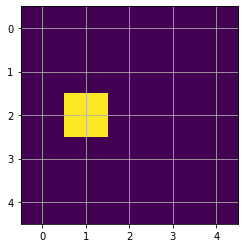

In [2]:
size = 5
image_space = np.zeros((size, size))

agent_pos = [2, 1]
image_space[agent_pos[0], agent_pos[1]] = 2

goal_pos = [2, 1]
image_space[goal_pos[0], goal_pos[1]] = 1

plt.imshow(image_space)
plt.grid()

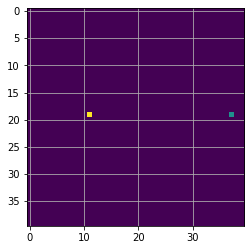

In [3]:
size = 40
image_space = np.zeros((size, size))

agent_pos = [2, 1]
image_space[agent_pos[0]*8 + 3, agent_pos[1]*8 + 3] = 2

goal_pos = [2, 4]
image_space[goal_pos[0]*8 + 3, goal_pos[1]*8 + 5] = 1

plt.imshow(image_space)
plt.grid()

In [4]:
arena_config = matrix2arena(image_space)
try:
    environment = AnimalAIEnvironment(
            file_name='../env/AnimalAI',
            base_port=5005,
            arenas_configurations=arena_config,
            play=True,
        )
except UnityCommunicationException:
    # you'll end up here if you close the environment window directly
    # always try to close it from script
    environment.close()

In [5]:
if environment:
    environment.close() # takes a few seconds

### Without running ray

Shortest path:  1


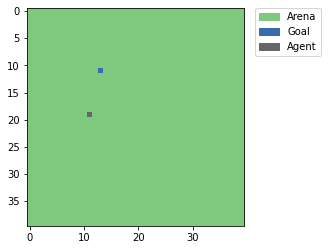

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  1000  Cumulative reward:  -0.9999999310821296  Episode Length:  496.0
Sum reward:  -0.9999999310821296


<Figure size 432x288 with 0 Axes>

In [2]:
env = gym.make("adversarial-v7")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

Shortest path:  5


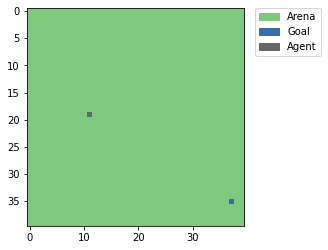

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  2000  Cumulative reward:  -0.9999999310821296  Episode Length:  496.0
Sum reward:  -0.9999999310821296


<Figure size 432x288 with 0 Axes>

In [3]:
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

## Running ray 

In [ ]:
import os
import shutil

chkpt_root = "tmp/trial"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [ ]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

In [ ]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v6 import Adversarial_v6
import ray.rllib.agents.ppo as ppo

select_env = "adversarial-v6"
register_env(select_env, lambda config: Adversarial_v4())

config = ppo.DEFAULT_CONFIG.copy()

config['num_workers'] = 0
config["log_level"] = "WARN"
config["train_batch_size"] = 1
config["sgd_minibatch_size"] = 1
config["num_sgd_iter"] = 1
config["timesteps_per_iteration"] = 4
config["rollout_fragment_length"] = 1

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

In [ ]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 100
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))